# 作业：手写数字加法机

本文件是与集智AI学园出品的系列课程“火炬上的深度学习”配套的作业notebook。本作业要求学员构造一个卷积神经网，输入两张手写数字图片，输出这两个数字的和。

本文件提供了一个完成做的大框架，学员需要自行修改、添加代码，从而完成任务

本文件是集智AI学园http://campus.swarma.org 出品的“火炬上的深度学习”第III课的配套源代码


In [144]:
# 导入所需要的包，请保证torchvision已经在你的环境中安装好
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.optim as optim
import torch.nn.functional as F

import torchvision.datasets as dsets
import torchvision.transforms as transforms

import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline

In [145]:
# 定义需要用到的超参数
image_size = 28  #图像的总尺寸28*28
num_classes = 10 #标签的种类数
batch_size = 64
use_gpu=torch.cuda.is_available()

# 加载MINIST数据，如果没有下载过，就会在当前路径下新建/data子目录，并把文件存放其中
train_dataset = dsets.MNIST(root='./data',  #文件存放路径
                            train=True,   #提取训练集
                            transform=transforms.ToTensor(),  #将图像转化为Tensor
                            download=True)
test_dataset = dsets.MNIST(root='./data', 
                           train=False, 
                           transform=transforms.ToTensor())


# 由于每一个样本需要输入两个图片，因此每一个loader和sampler都有两个
# sampler1 = torch.utils.data.sampler.SubsetRandomSampler(np.random.permutation(range(len(train_dataset))))
# sampler2 = torch.utils.data.sampler.SubsetRandomSampler(np.random.permutation(range(len(train_dataset))))


# 训练数据的两个加载器
train_loader1 = torch.utils.data.DataLoader(dataset = train_dataset,
                                            batch_size = batch_size,
                                            shuffle = True,
                                            pin_memory = use_gpu,
#                                            sampler = sampler1
                                           )
train_loader2 = torch.utils.data.DataLoader(dataset = train_dataset,
                                            batch_size = batch_size,
                                            shuffle = True,
                                            pin_memory = use_gpu,
#                                            sampler = sampler2
                                           )

# 校验数据和测试数据都各自有两套
val_size = 5000
val_indices1 = range(val_size)
val_indices2 = np.random.permutation(range(val_size))
val_sampler1 = torch.utils.data.sampler.SubsetRandomSampler(val_indices1)
val_sampler2 = torch.utils.data.sampler.SubsetRandomSampler(val_indices2)
val_loader1 = torch.utils.data.DataLoader(dataset = test_dataset,
                                          batch_size = batch_size,
                                          shuffle = False,
                                          sampler = val_sampler1,
                                          pin_memory = use_gpu,
                                         )
val_loader2 = torch.utils.data.DataLoader(dataset = test_dataset,
                                          batch_size = batch_size,
                                          shuffle = False,
                                          sampler = val_sampler2,
                                          pin_memory = use_gpu,
                                         )

test_indices1 = range(val_size, len(test_dataset))
test_indices2 = np.random.permutation(test_indices1)
test_sampler1 = torch.utils.data.sampler.SubsetRandomSampler(test_indices1)
test_sampler2 = torch.utils.data.sampler.SubsetRandomSampler(test_indices2)
test_loader1 = torch.utils.data.DataLoader(dataset = test_dataset,
                                           batch_size = batch_size,
                                           shuffle = False,
                                           sampler = test_sampler1,
                                           pin_memory = use_gpu,
                                          )
test_loader2 = torch.utils.data.DataLoader(dataset = test_dataset,
                                           batch_size = batch_size,
                                           shuffle = False,
                                           sampler = test_sampler2,
                                           pin_memory = use_gpu,
                                          )
print("数据加载完成")

数据加载完成


# MINST Adder

为了实现加法器，需要同时处理两个手写体数字图像，并对它进行相应的图像处理
因此，网络的架构为两个卷积神经网络，串联上两个全链接层

In [146]:
## 定义网络
depth = [8, 16]
class MINSTAdder(nn.Module):
    def __init__(self):
        super(MINSTAdder, self).__init__()
        #处理第一个图像处理用的卷积网络部件,采用5x5的卷积核
        self.net1_conv1 = nn.Conv2d(1, depth[0], 5, padding = 2)
        self.net1_conv2 = nn.Conv2d(depth[0], depth[1], 5, padding = 2)
        
        #处理第二个图像处理用的卷积网络部件,采用5x5的卷积核
        self.net2_conv1 = nn.Conv2d(1, depth[0], 5, padding = 2)
        self.net2_conv2 = nn.Conv2d(depth[0], depth[1], 5, padding = 2)

        #池化方式采用2x2
        self.net_pool = nn.MaxPool2d(2, 2)

        #后面的全连阶层，两步池化所以整除4
        self.fc1 = nn.Linear(2 * image_size // 4 * image_size // 4 * depth[1] , 512)
        self.fc2 = nn.Linear(512, 100)
        self.fc3 = nn.Linear(100, 20)   # 实际只需要18，故意多设置了几个

    def forward(self, x1, x2, training = True):
        #第一张图像的处理流程
        x1 = F.relu(self.net1_conv1(x1))
        x1 = self.net_pool(x1)
        x1 = F.relu(self.net1_conv2(x1))
        x1 = self.net_pool(x1)
        x1 = x1.view(-1, image_size // 4 * image_size // 4 * depth[1])
        
        #第二张图像的处理流程
        x2 = F.relu(self.net2_conv1(x2))
        x2 = self.net_pool(x2)
        x2 = F.relu(self.net2_conv2(x2))
        x2 = self.net_pool(x2)
        x2 = x2.view(-1, image_size // 4 * image_size // 4 * depth[1])
        
        #将前两部处理得到的张量并列到一起，喂给两层全链接前馈网络，最后输出预测数值
        nn = torch.cat((x1, x2), 1)
        nn = self.fc1(nn)
        nn = F.relu(nn)
        nn = self.fc2(nn)
        nn = F.relu(nn)
        nn = F.dropout(nn, 0.5, training) #以默认为0.5的概率对这一层进行dropout操作
        nn = self.fc3(nn)
#         nn = torch.round(nn)  # 整数化
        return nn


In [147]:
# 将网络定义为一个预测器，来对加法的结果进行预测，因此用MSE平均平房误差作为我们的损失函数
net = MINSTAdder()
if use_gpu:
    net.cuda()
# criterion = nn.MSELoss()          # 均方差
criterion = nn.CrossEntropyLoss()    # 交叉熵
optimizer = optim.SGD(net.parameters(), lr = 0.01, momentum = 0.9)

训练网络部分逻辑

In [148]:
# 错误率（有多少数字给出了严格的正确输出结果）
def error_rate(output, target):
    _, yy = torch.max(output, 1)
    yy = yy.type(torch.LongTensor).data.numpy()
#     yy = torch.round(output).type(torch.LongTensor).data.numpy().reshape(-1)
    tt = target.type(torch.LongTensor).data.numpy()
    return(100.0 - np.sum(yy == tt) / yy.size * 100.0)


# 校验模型
def eval_net(input1, input2):
    global net, criterion, use_gpu
    net.eval()
    losses = []
    errors = []
    for _, data in enumerate(zip(input1, input2)):
        ((x1, y1), (x2, y2)) = data
        if use_gpu:
            x1 = Variable(x1).cuda()
            x2 = Variable(x2).cuda()
            labels = Variable((y1 + y2)).cuda()
        else:
            x1 = Variable(x1)
            x2 = Variable(x2)
            labels = Variable((y1 + y2))
            
        outputs = net(x1,x2)
        loss = criterion(outputs, labels)
        losses.append(loss.data.cpu().numpy() if use_gpu else loss.data.numpy())
        error = error_rate(outputs, labels)
        errors.append(error)
    return (losses, errors)
            
def need_stop(train_er, val_er):
    # 通过移动平均值判断是否符合停止条件
    tmm10=train_er[-10:].mean()
    vmm10=val_er[-10:].mean()
    tmm20=train_er[-20:].mean()
    vmm20=val_er[-20:].mean()
    d = 0.1
    if len(train_er) >=10 and tmm10 < vmm10:
        # 过拟合
        return True
    if len(train_er) >=20 and (tmm20 - tmm10) < d:
        # 错误率长时间无变化
        return True
    return False

    
# 开始训练循环，本部分代码需要补齐
training_epochs = 100  #训练的总循环周期
records=[]
for epoch in range(training_epochs):
    losses = []
    errors = []
    # 一个关键技术难点是对两个数据加载器进行读取成对儿的数据。我们的办法是通过zip命令，将loader1和2并列在一起，一对一对的读取数据
    for idx, data in enumerate(zip(train_loader1, train_loader2)):
        ((x1, y1), (x2, y2)) = data
        if use_gpu:
            x1 = Variable(x1).cuda()
            x2 = Variable(x2).cuda()
            labels = Variable((y1 + y2)).cuda()
        else:
            x1 = Variable(x1)
            x2 = Variable(x2)
            labels = Variable((y1 + y2))
        
        # 训练
        optimizer.zero_grad()
        net.train()
        outputs = net(x1, x2)
#         print(outputs,labels)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        error = error_rate(outputs, labels)
        errors.append(error)
        losses.append(loss.data.cpu().numpy() if use_gpu else loss.data.numpy())
        
        # 每间隔一定周期就打印一下训练集、校验集的准确率结果
        if idx % 300 == 0:
            loss_mean = np.mean(losses)
            error_ratio = np.mean(errors)
            
            (val_losses, val_error_ratios)=eval_net(val_loader1, val_loader2)
            val_loss = np.mean(val_losses)
            val_error_ratio = np.mean(val_error_ratios)
#             print(losses)
            
            print('第{}周期, 第({}/{})个撮, 训练误差:{:.2f}, 错误率:{:.2f}%, 校验误差：{:.2f}, 校验错误率：{:.2f}%'
                  .format(epoch, idx, len(train_loader1), loss_mean, error_ratio, val_loss_mean, val_error_ratio))
            
            records.append([loss_mean, error_ratio, val_loss_mean, val_error_ratio])
    
    if need_stop(np.array(records)[:,1], np.array(records)[:,3]):
        break

第0周期, 第(0/938)个撮, 训练误差:3.01, 错误率:100.00%, 校验误差：1.62, 校验错误率：97.41%
第0周期, 第(300/938)个撮, 训练误差:2.84, 错误率:91.15%, 校验误差：1.62, 校验错误率：89.22%
第0周期, 第(600/938)个撮, 训练误差:2.78, 错误率:90.06%, 校验误差：1.62, 校验错误率：86.65%
第0周期, 第(900/938)个撮, 训练误差:2.63, 错误率:87.72%, 校验误差：1.62, 校验错误率：79.91%
第1周期, 第(0/938)个撮, 训练误差:2.24, 错误率:87.50%, 校验误差：1.62, 校验错误率：79.81%
第1周期, 第(300/938)个撮, 训练误差:1.96, 错误率:72.19%, 校验误差：1.62, 校验错误率：62.82%
第1周期, 第(600/938)个撮, 训练误差:1.70, 错误率:60.93%, 校验误差：1.62, 校验错误率：38.75%
第1周期, 第(900/938)个撮, 训练误差:1.44, 错误率:50.27%, 校验误差：1.62, 校验错误率：26.68%
第2周期, 第(0/938)个撮, 训练误差:0.97, 错误率:26.56%, 校验误差：1.62, 校验错误率：26.21%
第2周期, 第(300/938)个撮, 训练误差:0.65, 错误率:19.38%, 校验误差：1.62, 校验错误率：19.30%
第2周期, 第(600/938)个撮, 训练误差:0.59, 错误率:17.63%, 校验误差：1.62, 校验错误率：14.81%
第2周期, 第(900/938)个撮, 训练误差:0.55, 错误率:16.30%, 校验误差：1.62, 校验错误率：13.35%
第3周期, 第(0/938)个撮, 训练误差:0.63, 错误率:15.62%, 校验误差：1.62, 校验错误率：14.85%
第3周期, 第(300/938)个撮, 训练误差:0.40, 错误率:11.64%, 校验误差：1.62, 校验错误率：11.37%
第3周期, 第(600/938)个撮, 训练误差:0.38, 错误率:10.74%, 校验误差：1.62, 校验错误率：12.62%
第3

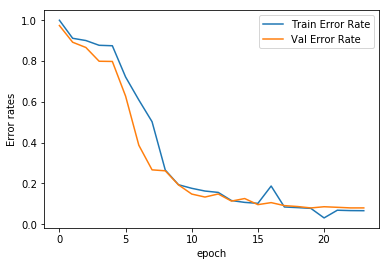

In [149]:
## 训练数据与校验数据错误率曲线
plt.plot(np.arange(len(records)), np.array(records)[:,1] / 100.0, label = 'Train Error Rate')
plt.plot(np.arange(len(records)), np.array(records)[:,3] / 100.0, label = 'Val Error Rate')
plt.xlabel('epoch')
plt.ylabel('Error rates')
plt.legend()

测试集错误率:0.04% 正确率:99.96%


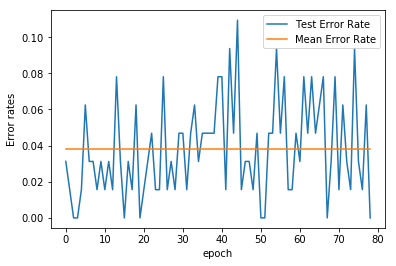

In [150]:
# 在测试集上运行我们的加法机网络，并测试预测准确度

(losses, errors)=eval_net(test_loader1, test_loader2)
plt.plot(np.arange(len(errors)), np.array(errors) / 100.0, label = 'Test Error Rate')
plt.plot(np.arange(len(errors)), np.ones(len(errors))*np.mean(errors) / 100.0, label = 'Mean Error Rate')
plt.xlabel('epoch')
plt.ylabel('Error rates')
plt.legend()

test_er=np.mean(errors)/100
print("测试集错误率:{:.2f}% 正确率:{:.2f}%".format(test_er, 100.0-test_er))

### 作业与实验总结

* 分类模型将正确率做到 99.96%
* 分类方法比预测方法正确率提高明显，预测方法在50%左右；
* 通过比对模型在验证集与训练集上的表现来停止训练；
* 使用GPU加速；
* 目前GPU使用率不高，怀疑是频繁数据拷贝导致，可以考虑通过一次将数据加载入GPU增加训练速度；